# Weight initialization

Some experiments to examine the impact of weight initialization on the distribution of activations on each layer in neural network, especially the very last layers. This was mentioned by Andrej in [cs231n/lec6](https://www.youtube.com/watch?v=hd_KFJ5ktUc&index=6&list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC) as a motivation paving the way for batch normalization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils.data_utils import get_CIFAR10_data

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [3]:
X_train = data['X_train']
X_train_flat = X_train.reshape((-1, 32*32*3))
X_train_normalized = (X_train_flat - X_train_flat.mean(axis=0)) / (X_train_flat.std(axis=0) + 1e-8)

In [4]:
def relu(x):
    return np.maximum(x, 0)

def forward(X_flat, hid_dims, weights, biases, activation=relu):
    """
    Feed forward.
     - X_flat: shape: N x D, where D = d1 x ... x dk.
     - hid_dims: 1D array.
     - weights: array of weights: W1, W2, ...
     - biases: array of biases: b1, b2, ...
     - activation: activation on each layer. None if no activation.
    """
    assert len(weights) == len(biases), 'weights and biases must have the same length'
    assert len(hid_dims) + 1 == len(weights), 'len(weights) must equal len(hid_dims) + 1'
    
    all_layers = []
    out = X_flat
    for l in range(len(hid_dims) + 1):
        out = np.dot(out, weights[l]) + biases[l]
        if activation is not None:
            out = activation(out)
        all_layers.append(out)
    
    return out, all_layers

In [5]:
def visualize_distribution(all_activations):
    n_layers = len(all_activations)
    activations_mean = [np.asscalar(np.mean(activations)) for activations in all_activations]
    activations_std = [np.asscalar(np.std(activations)) for activations in all_activations]
    
    xs = range(1, n_layers+1)
    _, axes = plt.subplots(2, 2, figsize=(8, 8))
    ax1, ax2, ax3, ax4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]
    ax1.plot(xs, activations_mean, '-o', color='#0067a7')
    ax1.set_title('means by layer')
    ax1.set_xlabel('layer')
    ax2.plot(xs, activations_std, '-o', color='red')
    ax2.set_title('std by layer')
    ax2.set_xlabel('layer')
    
    ax3.hist(all_activations[14].ravel(), bins=50, color='green')
    ax3.set_title('Distribution of layer 15')
    ax4.hist(all_activations[-1].ravel(), bins=50, color='green')
    ax4.set_title('Distribution of the layer %d' % n_layers)
    
    plt.tight_layout()
    plt.show()
    
    # Print mean and std of last 5 layer
    for l in range(n_layers)[-5:]:
        print('Layer %2d. mean: %f\tstd: %f' % (l+1, activations_mean[l], activations_std[l]))
    
def initialize_params(in_dim, hid_dims, out_dim,
                      weight_initializer=np.random.randn,
                      bias_initializer=np.zeros):
    dims = [in_dim] + hid_dims + [out_dim]
    weights, biases = [], []
    for l in range(len(hid_dims) + 1):
        w = weight_initializer(dims[l], dims[l+1])
        b = bias_initializer(dims[l+1])
        weights.append(w)
        biases.append(b)
    return weights, biases

def examine_distribution(weight_initializer, activation=relu, n_layers=20):
    in_dim, out_dim = 32*32*3, 10
    hid_dims = [100 for i in range(n_layers - 1)]
    
    weights, biases = initialize_params(in_dim, hid_dims, out_dim,
        weight_initializer=weight_initializer)
    
    _, all_activations = forward(X_train_normalized, hid_dims=hid_dims, 
        weights=weights, biases=biases, activation=activation)
    
    visualize_distribution(all_activations)

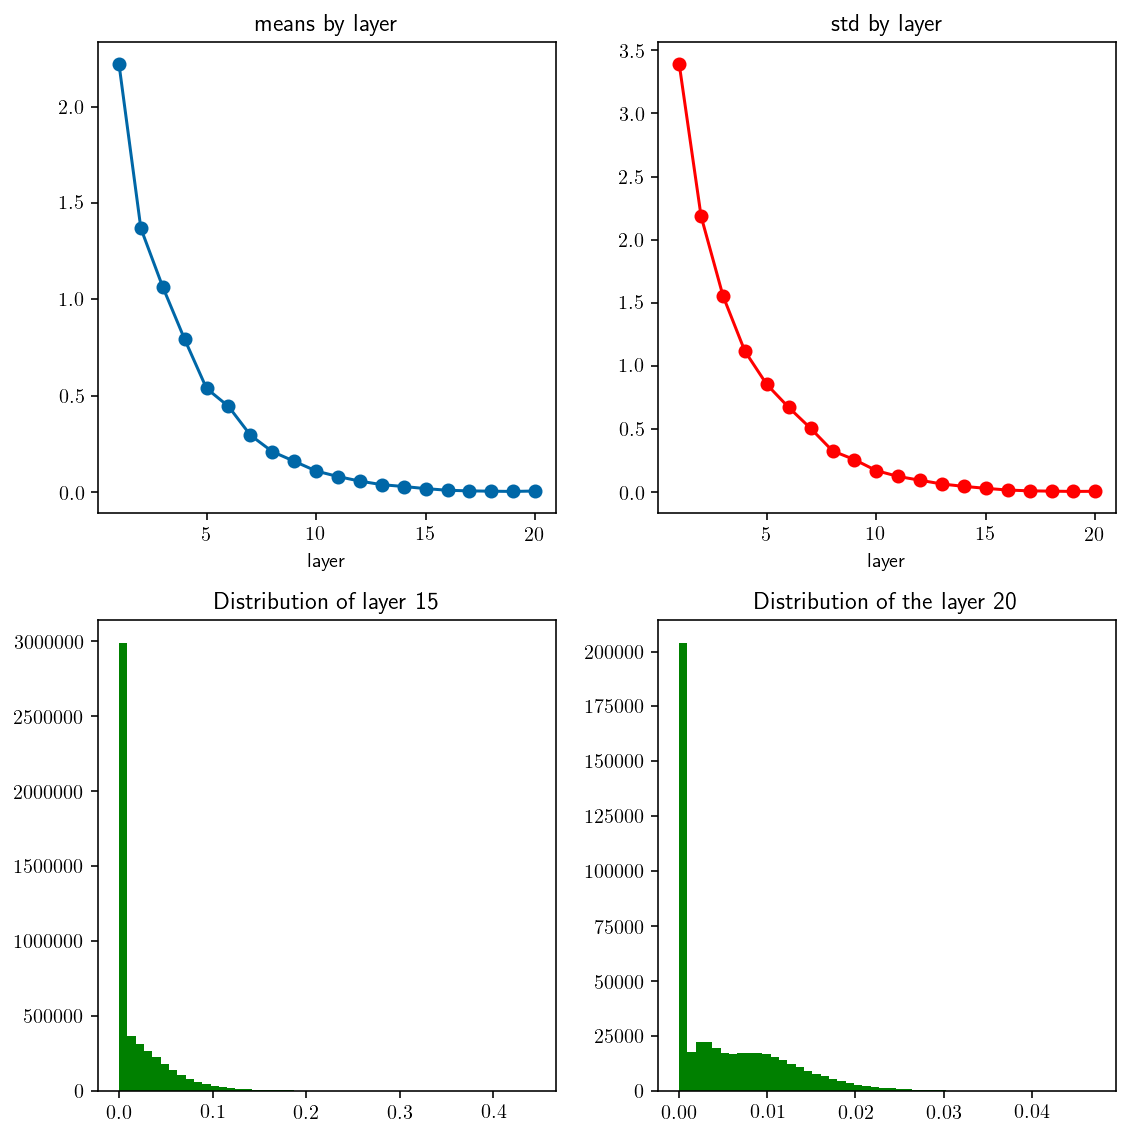

Layer 16. mean: 0.009006	std: 0.016165
Layer 17. mean: 0.005849	std: 0.009699
Layer 18. mean: 0.004207	std: 0.007308
Layer 19. mean: 0.002917	std: 0.004961
Layer 20. mean: 0.005232	std: 0.006176


In [6]:
def trivial_initializer(d1, d2, weight_scale=0.1):
    return np.random.normal(0, weight_scale, (d1, d2))

examine_distribution(trivial_initializer)

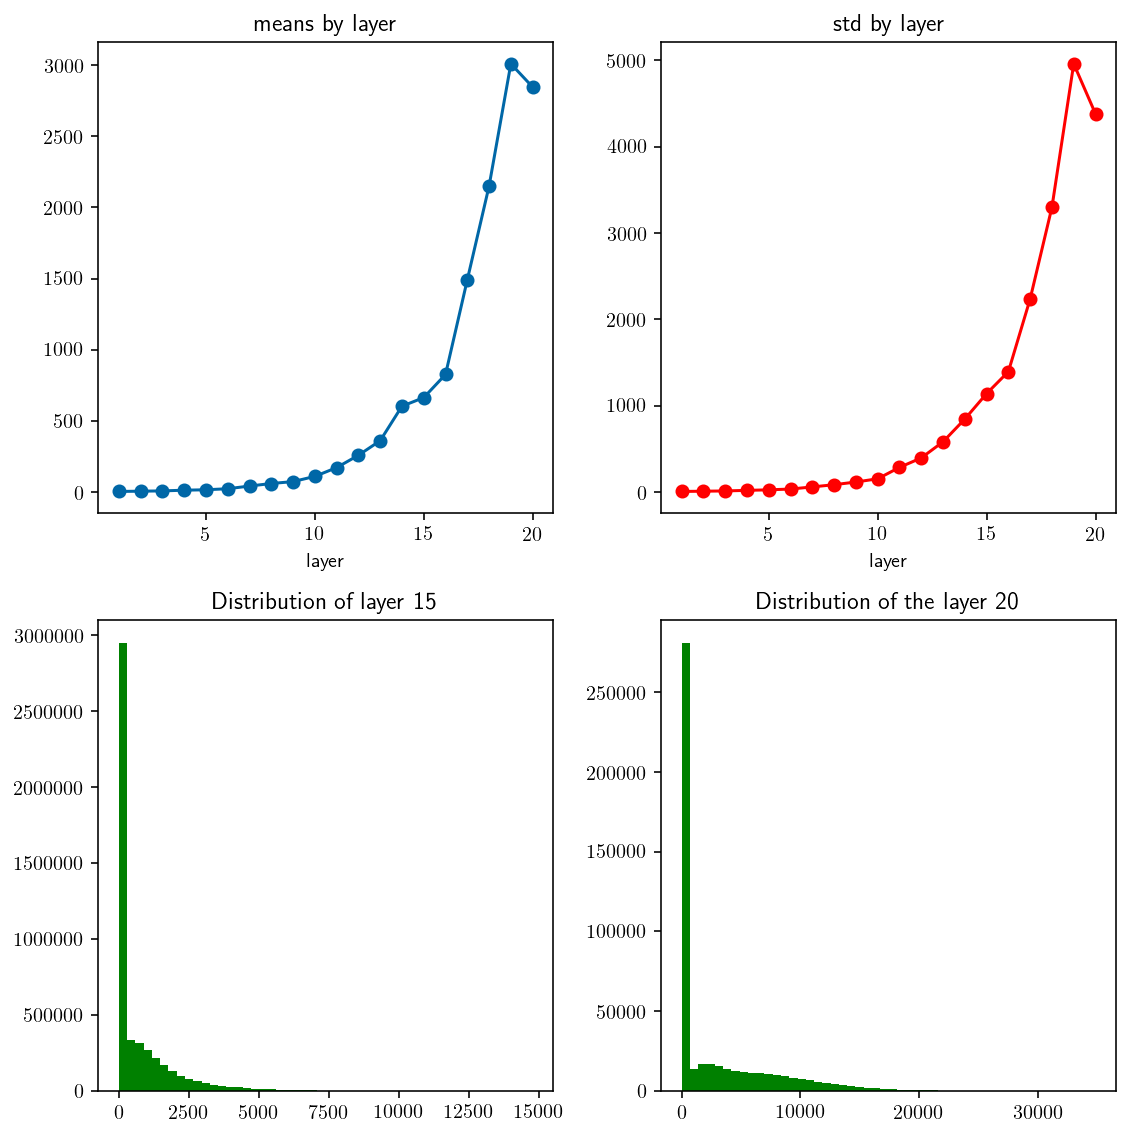

Layer 16. mean: 825.965548	std: 1394.566496
Layer 17. mean: 1491.038728	std: 2237.786857
Layer 18. mean: 2149.680649	std: 3300.200497
Layer 19. mean: 3008.496905	std: 4961.155125
Layer 20. mean: 2845.114905	std: 4381.190124


In [7]:
examine_distribution(lambda d1, d2: trivial_initializer(d1, d2, weight_scale=0.2))

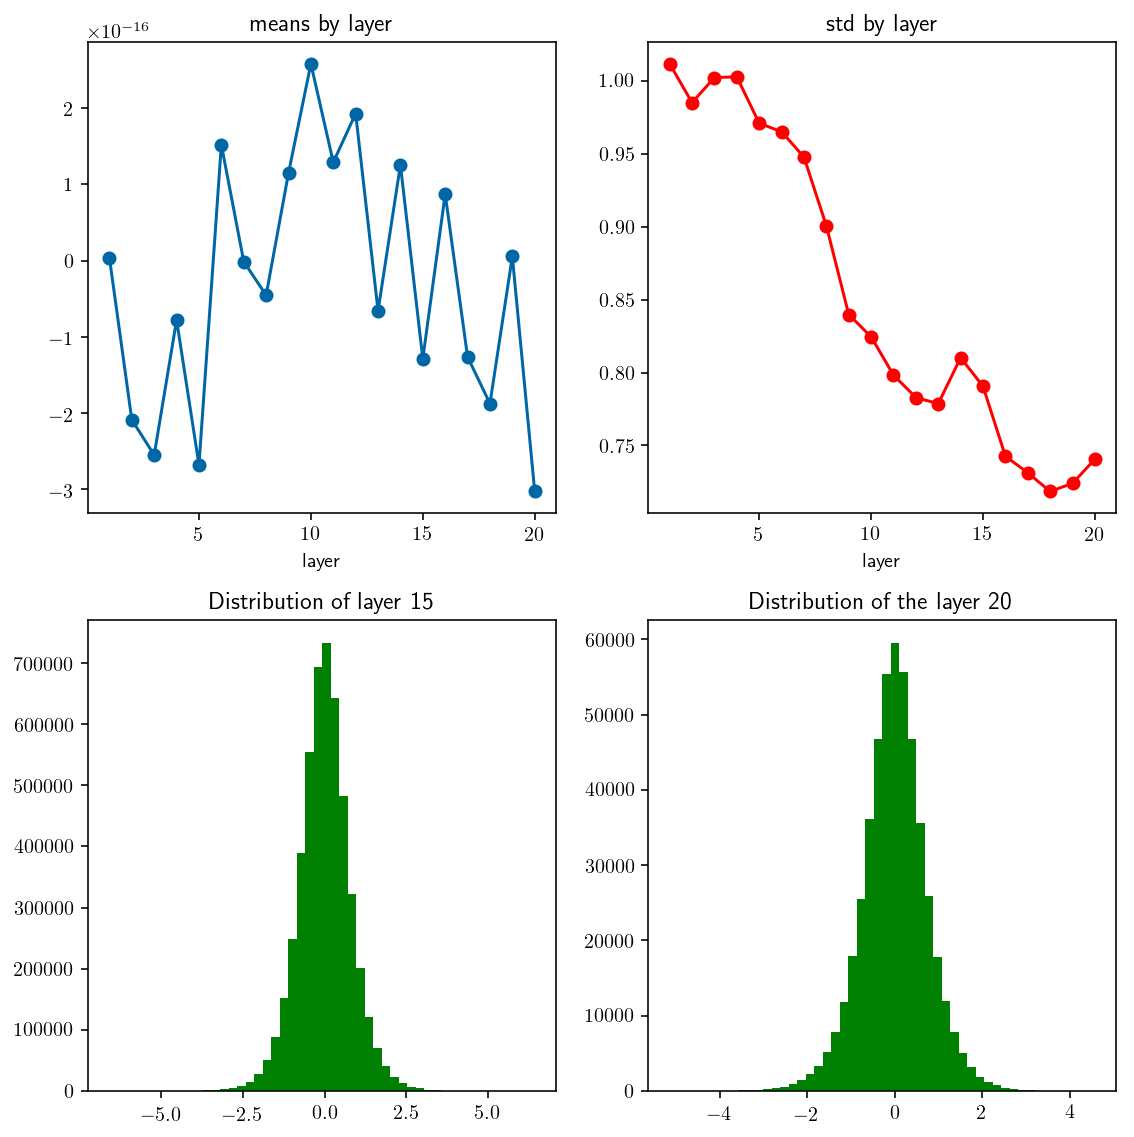

Layer 16. mean: 0.000000	std: 0.742681
Layer 17. mean: -0.000000	std: 0.731260
Layer 18. mean: -0.000000	std: 0.718502
Layer 19. mean: 0.000000	std: 0.724088
Layer 20. mean: -0.000000	std: 0.740663


In [8]:
def xavier_initializer_1(d1, d2):
    return np.random.randn(d1, d2) * np.sqrt(1.0 / d1)

examine_distribution(xavier_initializer_1, activation=None)

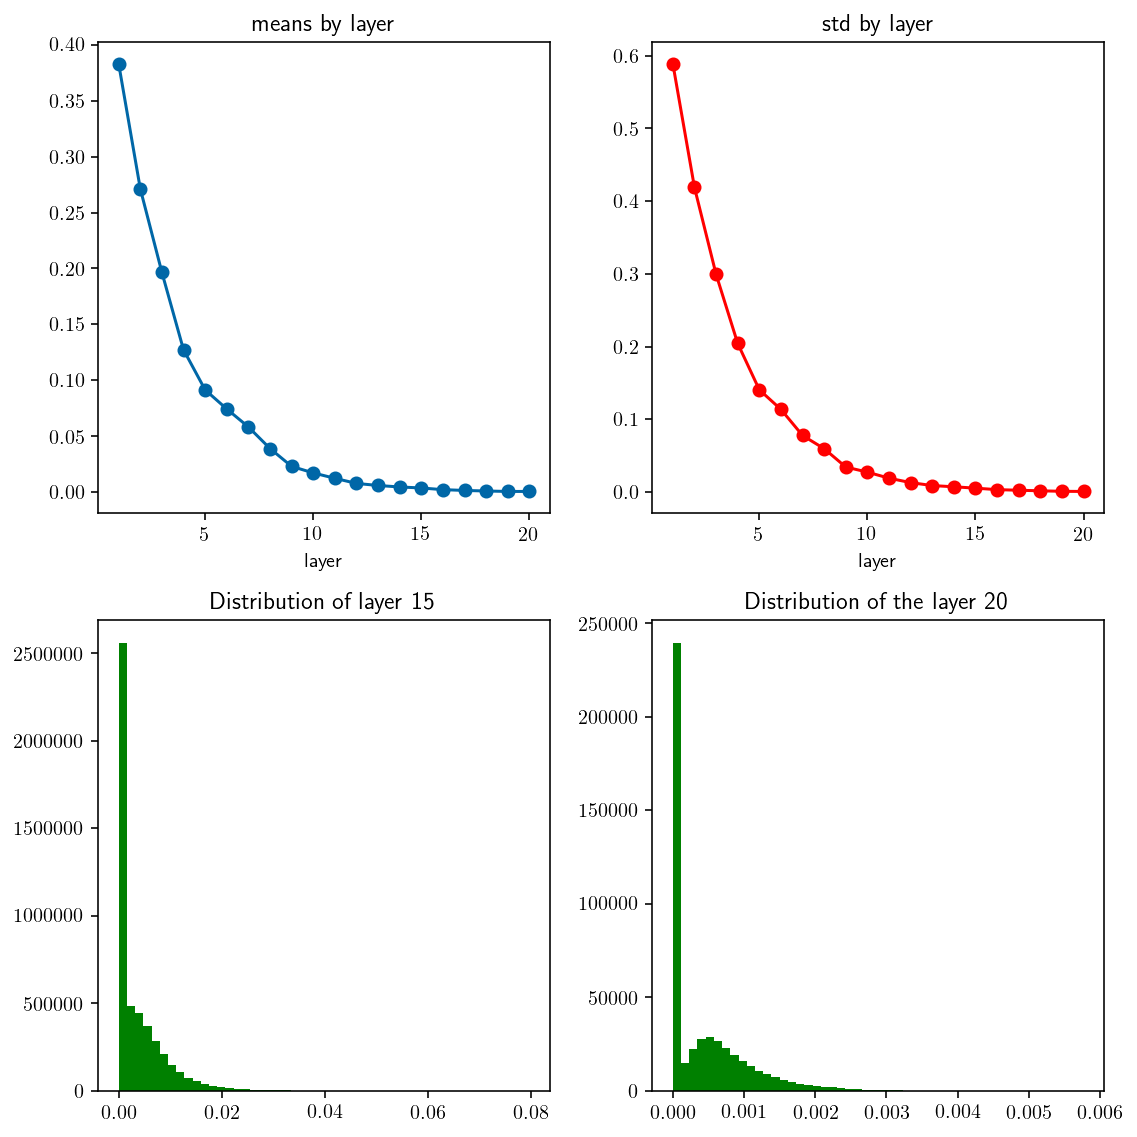

Layer 16. mean: 0.002048	std: 0.003093
Layer 17. mean: 0.001338	std: 0.002246
Layer 18. mean: 0.000834	std: 0.001481
Layer 19. mean: 0.000434	std: 0.000776
Layer 20. mean: 0.000440	std: 0.000590


In [9]:
examine_distribution(xavier_initializer_1, activation=relu)

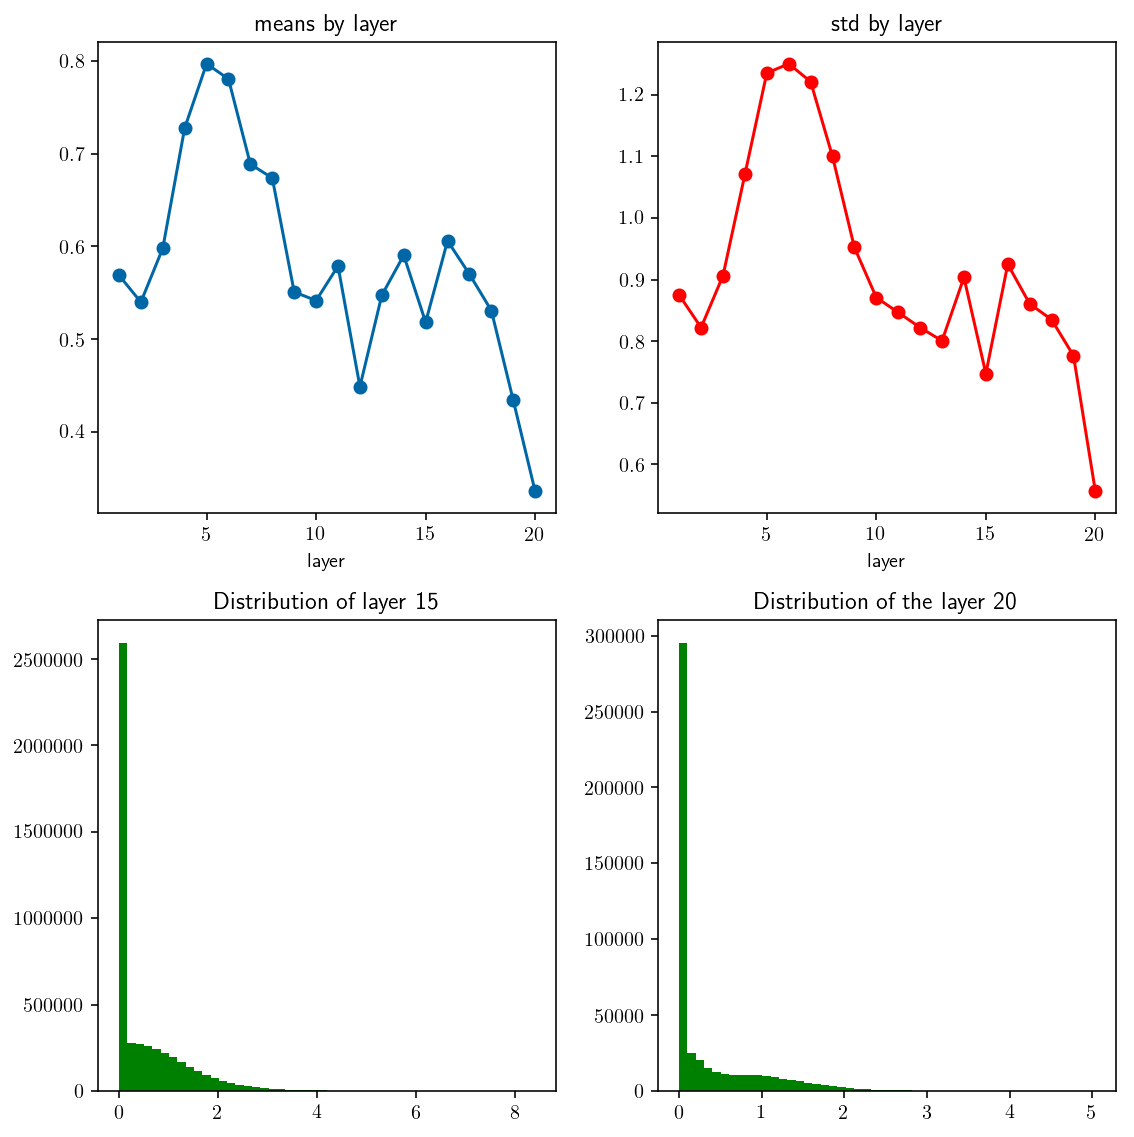

Layer 16. mean: 0.605864	std: 0.924794
Layer 17. mean: 0.569898	std: 0.860651
Layer 18. mean: 0.530719	std: 0.835036
Layer 19. mean: 0.433965	std: 0.776518
Layer 20. mean: 0.335705	std: 0.556218


In [10]:
def xavier_initializer_2(d1, d2):
    return np.random.randn(d1, d2) * np.sqrt(2.0 / d1)

examine_distribution(xavier_initializer_2)